# Connect and authorize google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal/
!ls

In [3]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML_HI/tano_signal


# Install

In [ ]:
! pip install spectral_cube

# Libraries

In [8]:
import sys
import os
import copy
import torch

import numpy as np
import pandas as pd

from astropy.io  import fits
from astropy     import units as u
from astropy.wcs import WCS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from spectral_cube import SpectralCube

from pathlib import Path

In [6]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# GPU or CPU

In [9]:
# GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)
print('device_count: ', torch.cuda.device_count())

device:  cpu
device_count:  0


# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML/')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct101_checkpoint_path = checkpoint_path / 'c101'
ct256_checkpoint_path = checkpoint_path / 'c256_1split'
cnn101_checkpoint_path = checkpoint_path / 'cnn' / 'c101'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'
bighicat = tanosignal_path / 'bighicat'

saury2014_data_path = data_path / 'saury'
seta_data_path = data_path / 'seta'

print(tano_signal_path)
print(checkpoint_path)
print(ct101_checkpoint_path)
print(cnn101_checkpoint_path)
print('UMA: ', uma_data_path)
print('Saury 2014: ', saury2014_data_path)

# Utils

In [11]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube

    # c = c[:, 10:29, 10:29]

    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header
    # w = WCS(hdr)

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()  # Close the FITS file - we already read it in and don't need it anymore!

    print(f"Cube shape: {c.shape}") # (vlsr, b, l) : (971, 201, 376)

    del dat
    # cube = cube.with_spectral_unit(u.km / u.s)

    _, _, x = c.world[0, 0, :]      # extract RA: deg
    _, y, _ = c.world[0, :, 0]      # extract DEC:  deg
    v, _, _ = c.world[:, 0, 0]      # extract velocity

    return c, w, x, y, v, hdr

In [12]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

# Read BIGHICAT

In [13]:
bighicat_csvfile = bighicat / 'all_unique_LOS_BIGHICAT.csv'
bighicat_df = pd.read_csv(bighicat_csvfile)
print('nrows, ncols: ', bighicat_df.shape)
bighicat_df

nrows, ncols:  (374, 39)


,source,survey,lon,lat,ra,dec,NHI_LOS,f_CNM_LOS,f_WNM_LOS,NHI_CNM_LOS,...,e_f_CNM_LOS_KOK14,nhi_thin,signhi_thin,rhi,sigrhi,rhi_ctrans,sigrhi_ctrans,fcnm_ctrans,sigfcnm_ctrans,"Note v1, v2, noise"
0,J0022,21-SPONGE,107.461730,-61.748239,5.605941,0.248934,2.642248,0.040872,0.627534,0.107994,...,0.034327,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3C018A,21-SPONGE,118.623255,-52.731718,10.211263,10.051389,6.287702,0.523649,0.476351,3.292549,...,0.263721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3C018B,21-SPONGE,118.616421,-52.718907,10.206185,10.063889,6.273332,0.525139,0.474861,3.294371,...,0.258198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3C041A,21-SPONGE,131.378783,-29.074651,21.686793,33.217306,5.463896,0.004445,0.630555,0.024289,...,0.045187,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3C041B,21-SPONGE,131.373859,-29.069848,21.682609,33.222722,5.468773,0.161569,0.838431,0.883582,...,0.047690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,J17305,MACH,62.989300,31.515300,262.725150,38.197218,3.340000,0.080000,0.920000,0.267200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,J17395,MACH,74.222100,31.396300,264.987619,47.632615,2.100000,0.010000,0.990000,0.021000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,J17403,MACH,79.563300,31.748300,265.153694,52.195089,2.930000,0.010000,0.990000,0.029300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372,J17422,MACH,81.770200,31.613400,265.597628,54.059010,3.160000,0.060000,0.940000,0.189600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
bighicat_fcnm = bighicat_df.f_CNM_LOS.values
bighicat_fcnm.shape

(374,)

In [15]:
z_df = bighicat_df[~bighicat_df.survey.isin(['MACH', '21-SPONGE', 'Millennium03'])]
z_df = z_df[z_df.ncomps > -1]
print(z_df.shape)
z_gl = z_df.lon.values
z_gb = z_df.lat.values
z_ncnm = z_df.ncomps.values

bighicat_fcnm = z_df.f_CNM_LOS.values

(222, 39)


# SPONGE

In [16]:
sp_csvfile = bighicat / '21SPONGE_rl_ew.csv'
spdf = pd.read_csv(sp_csvfile)
spdf = spdf.drop([27, 41]) # Drop 3C245B, J1613 (no result)
spdf

,NVSS,Name,Rej,RAJ2000,DEJ2000,S1.4GHz,Beam1,Beam2,errTau,TauPk,...,rhi_rl,sigrhi_rl,fcnm_rl,sigfcnm_rl,note_rl,lon,lat,ew,sigew,taupeak
0,1,J0022,NaN,00 22 25.4,+00 14 56.2,3.01,2.2,1.4,0.8,0.025,...,1.004219,0.002808,0.038753,0.025516,"-50.0, 35.0, 0.0",107.461730,-61.748239,0.152596,0.006093,0.025008
1,1,3C018A,NaN,00 40 50.7,+10 03 05.0,4.60,15.5,13.7,1.5,0.623,...,1.283455,0.090160,0.669924,0.058564,"-50.0, 35.0, 0.0",118.623255,-52.731718,2.388960,0.012099,0.623266
2,1,3C018B,NaN,00 40 49.5,+10 03 50.0,4.60,15.5,13.7,2.4,0.642,...,1.283455,0.090160,0.669924,0.058564,"-50.0, 35.0, 0.0",118.616421,-52.718907,2.350025,0.018069,0.646219
3,1,3C041A,NaN,01 26 44.8,+33 13 02.3,3.71,1.7,1.4,2.4,0.039,...,1.031608,0.015288,0.308975,0.034697,"-90.0, 50.0, 0.0",131.378783,-29.074651,0.425712,0.019103,0.039869
4,1,3C041B,NaN,01 26 43.8,+33 13 21.8,3.71,1.7,1.4,3.8,0.057,...,1.023121,0.016231,0.276679,0.055719,"-80.0, 40.0, 0.0",131.373859,-29.069848,0.414389,0.028003,0.058592
5,1,3C48,NaN,01 37 41.3,+33 09 35.1,16.02,1.3,1.2,0.7,0.050,...,1.045387,0.007786,0.417322,0.016107,"-90.0, 80.0, 0.0",133.962566,-28.719406,0.397174,0.006316,0.050649
6,1,4C15.05,NaN,02 04 50.4,+15 14 11.0,4.07,3.3,3.0,0.6,0.086,...,1.091353,0.038550,0.595234,0.014628,"-90.0, 80.0, 0.0",147.930237,-44.043499,0.737596,0.005587,0.086753
7,2,3C78,NaN,03 08 26.2,+04 06 39.0,5.75,4.1,2.2,2.2,1.366,...,1.252841,0.059012,0.617025,0.009583,"-90.0, 80.0, 0.0",174.858069,-44.513511,4.984242,0.019157,1.366020
8,1,4C16.09,NaN,03 18 57.8,+16 28 32.7,8.03,1.4,1.2,0.6,0.539,...,1.339372,0.022660,0.723655,0.031929,"-80.0, 80.0, 0.0",166.635682,-33.595918,3.007419,0.006053,0.539776
9,1,3C111A,NaN,04 18 21.3,+38 01 35.8,7.73,13.0,5.3,1.7,0.888,...,1.716662,0.284000,0.800403,0.092686,"-80.0, 80.0, 0.0",161.675526,-8.819784,10.195482,0.019870,0.889239


In [17]:
sp21_fcnm    = spdf['fcnm'].values
sp21_sigfcnm = spdf['sigfcnm'].values

sp21_rhi    = spdf['rhi'].values
sp21_sigrhi = spdf['sigrhi'].values

sp21_lat    = np.abs(spdf.lat.values)

sp21_fcnm.shape

(54,)

# MACH

In [18]:
mach_csvfile = bighicat / 'mach_los_rl_ew.csv'
mdf = pd.read_csv(mach_csvfile)
mdf

,source,survey,glon,glat,nhithin,signhithin,nhi,signhi,rhi,sigrhi,fcnm,sigfcnm,rhi_rl,sigrhi_rl,fcnm_rl,sigfcnm_rl,note_rl,ew,sigew,taupeak
0,J14002,MACH,109.589,53.127,1.40,0.11,1.40,0.11,1.00,0.11,0.00,0.00,1.001960,0.060877,0.001100,0.247028,"-150.0, 90.0, 0.0",0.003798,0.022471,0.011000
1,J14364,MACH,105.174,49.730,1.30,0.08,1.30,0.08,1.00,0.09,0.00,0.00,1.000000,0.010566,0.001100,0.093187,"-50.0, 40.0, 0.0",0.044586,0.035833,0.028944
2,J14384,MACH,103.524,50.695,1.50,0.13,1.50,0.13,1.00,0.12,0.00,0.00,1.000000,0.003423,0.001100,0.016570,"-50.0, 40.0, 0.0",0.014782,0.018303,0.009019
3,J14434,MACH,88.257,58.314,2.29,0.23,2.29,0.23,1.00,0.14,0.01,0.02,1.000145,0.007037,0.013046,0.041951,"-50.0, 40.0, 0.0",0.102064,0.017665,0.036370
4,J14510,MACH,71.913,61.477,1.46,0.05,1.47,0.05,1.00,0.05,0.00,0.01,1.000000,0.002100,0.003473,0.007674,"-20.0, 20.0, 0.0",0.001567,0.030739,0.030863
5,J14540,MACH,85.672,57.249,1.35,0.04,1.35,0.04,1.00,0.04,0.00,0.00,1.000000,0.002123,0.001100,0.001256,"-50.0, 40.0, 0.0",0.005037,0.056050,0.033030
6,J15040,MACH,97.691,50.106,1.11,0.09,1.11,0.09,1.00,0.11,0.00,0.00,1.000000,0.002089,0.002680,0.003566,"-50.0, 40.0, 0.0",0.019972,0.022608,0.018480
7,J15075,MACH,99.785,48.310,1.32,0.09,1.32,0.09,1.00,0.10,0.00,0.00,1.000000,0.002077,0.003079,0.002806,"-50.0, 40.0, 0.0",0.006704,0.056038,0.032039
8,J15102,MACH,87.319,53.685,1.70,0.07,1.70,0.07,1.00,0.06,0.00,0.00,1.000000,0.002088,0.012387,0.014226,"-50.0, 40.0, 0.0",0.077765,0.064493,0.047925
9,J15394,MACH,95.340,45.854,1.66,0.11,1.66,0.11,1.00,0.09,0.00,0.00,1.000000,0.002126,0.001100,0.001766,"-50.0, 40.0, 0.0",0.114269,0.074381,0.036885


In [19]:
m_fcnm    = mdf['fcnm'].values
m_sigfcnm = mdf['sigfcnm'].values

m_rhi    = mdf['rhi'].values
m_sigrhi = mdf['sigrhi'].values

m_lat = np.abs(mdf.glat.values)

m_fcnm.shape

(44,)

# MS (HT03)

In [20]:
ms_csvfile = bighicat / 'ms_los_rl_ew.csv'
msdf = pd.read_csv(ms_csvfile)
print(msdf.shape)
msdf

(61, 23)


,src,gl,gb,nhi,signhi,thin,sigthin,nhicnm,signhicnm,nhiwnm,...,fcnm,sigfcnm,rhi_rl,sigrhi_rl,fcnm_rl,sigfcnm_rl,note_rl,ew,sigew,taupeak
0,3C33,129.4481,-49.3244,2.7800,0.0400,2.8239,0.0680,1.64,0.0232,1.1400,...,0.589928,0.011904,1.031715,0.026357,0.500060,0.024573,"-80.0, 70.0, 0.0",0.270923,0.001908,0.027858
1,3C18,118.6218,-52.7266,5.9900,0.9500,5.1766,0.0315,5.24,0.9450,0.7500,...,0.874791,0.210090,1.172449,0.037589,0.691970,0.032398,"-70.0, 60.0, 0.0",3.253209,0.005509,0.771210
2,3C75-2,170.2958,-44.9192,8.2300,0.2100,7.7794,0.8588,2.14,0.1823,6.0900,...,0.260024,0.023123,1.147537,1.083771,0.496307,0.168487,"-20.0, 20.0, 0.0",2.614056,0.036579,0.741430
3,3C75-1,170.2162,-44.9112,7.9700,0.2000,7.5283,0.9967,2.05,0.1777,5.9200,...,0.257215,0.023212,1.069234,0.009061,0.532002,0.059011,"-60.0, 60.0, 0.0",2.444588,0.062241,0.857350
4,3C33-1,129.4392,-49.3432,2.8100,0.1200,2.7894,0.8383,1.95,0.0886,0.8600,...,0.693950,0.043271,1.036874,0.016365,0.480810,0.013394,"-70.0, 60.0, 0.0",0.378233,0.023290,0.042503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,3C190.0,207.6242,21.8412,2.8200,0.0400,2.9410,0.8069,0.00,0.0000,2.8200,...,0.000000,0.000000,1.005316,0.007794,0.013028,0.030847,"-35.0, 55.0, 0.0",0.017910,0.035522,0.047145
57,P0320+05,176.9818,-40.8433,11.2000,0.4800,9.9975,0.7438,5.05,0.3183,6.1500,...,0.450893,0.034367,1.280580,0.132321,0.609620,0.087970,"-50.0, 33.0, 0.0",5.576402,0.028833,0.585616
58,3C274.1,269.8744,83.1637,2.3600,0.0400,2.2860,0.1201,0.30,0.0193,2.0600,...,0.127119,0.008457,1.013350,0.026340,0.158648,0.174069,"-50.0, 25.0, 0.0",0.474076,0.007154,0.109415
59,3C207,212.9680,30.1390,5.2500,0.1500,4.9461,0.0969,0.91,0.1267,4.3400,...,0.173333,0.024636,1.018102,0.016438,0.218570,0.068050,"-36.0, 33.0, 0.0",2.209576,0.004200,0.296182


In [21]:
ms_csvfile = bighicat / 'nhi_lb_79src_HT03.txt'
msdf = pd.read_csv(ms_csvfile)
print('nrows, ncols:', msdf.shape)
msdf

nrows, ncols: (79, 21)


,id,src,gl,gb,nhi,signhi,thin,sigthin,nhicnm,signhicnm,...,signhiwnm,rhi,sigrhi,fcnm,sigfcnm,rhi_rl,sigrhi_rl,fcnm_rl,sigfcnm_rl,note_rl
0,0,3C33,129.4481,-49.3244,2.7800,0.0400,2.8239,0.0680,1.64,0.0232,...,0.0357,1.000000,0.027615,0.589928,0.011904,NaN,NaN,NaN,NaN,NaN
1,1,3C18,118.6218,-52.7266,5.9900,0.9500,5.1766,0.0315,5.24,0.9450,...,0.0561,1.157130,0.183653,0.874791,0.210090,NaN,NaN,NaN,NaN,NaN
2,2,3C141.0,174.5324,-1.3112,52.6900,1.4800,40.9027,0.5363,23.64,1.2509,...,0.7996,1.288179,0.039931,0.448662,0.026878,NaN,NaN,NaN,NaN,NaN
3,3,3C142.1,197.6157,-14.5115,21.9600,2.3000,17.2260,0.7261,8.10,2.2459,...,0.5171,1.274817,0.143926,0.368852,0.109325,NaN,NaN,NaN,NaN,NaN
4,4,3C138,187.4052,-11.3437,19.8400,0.9900,17.4826,0.2399,10.69,0.9004,...,0.4088,1.134843,0.058730,0.538810,0.052749,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,74,P0320+05,176.9818,-40.8433,11.2000,0.4800,9.9975,0.7438,5.05,0.3183,...,0.3610,1.120280,0.096187,0.450893,0.034367,NaN,NaN,NaN,NaN,NaN
75,75,3C274.1,269.8744,83.1637,2.3600,0.0400,2.2860,0.1201,0.30,0.0193,...,0.0293,1.032371,0.056991,0.127119,0.008457,NaN,NaN,NaN,NaN,NaN
76,76,3C207,212.9680,30.1390,5.2500,0.1500,4.9461,0.0969,0.91,0.1267,...,0.0870,1.061442,0.036772,0.173333,0.024636,NaN,NaN,NaN,NaN,NaN
77,77,T0629+10,201.5315,0.5079,59.2500,2.8600,45.1748,0.1705,37.02,2.5766,...,1.2404,1.311572,0.063503,0.624810,0.052922,NaN,NaN,NaN,NaN,NaN


In [22]:
ms_fcnm    = msdf['fcnm'].values
ms_sigfcnm = msdf['sigfcnm'].values

ms_rhi    = msdf['rhi'].values
ms_sigrhi = msdf['sigrhi'].values

ms_lat = np.abs(msdf.gb.values)

ms_fcnm.shape

(79,)

# GNOMES

In [23]:
gn_csvfile = bighicat / 'GNOMES.csv'
gndf = pd.read_csv(gn_csvfile)
print('nrows, ncols: ', gndf.shape)
gndf

nrows, ncols:  (77, 20)


,Source name,src,R.A (J2000),DEC (J2000),l(deg),b(deg),Flux(1.4GHz) in Jy,Tsky (K),nhi,signhi,nhithin,signhithin,rhi,sigrhi,nhicnm,signhicnm,nhiwnm,signhiwnm,fcnm,sigfcnm
0,J034053+073525 (4C+07.13),4C+07.13,03:40:53.73,07:35:25.40,178.87,-36.27,1.01,4.07,16.571832,0.889309,13.690089,0.038405,1.210499,0.065049,7.336882,0.675508,9.234950,0.578411,0.442732,0.047181
1,J032153+122114 (PKS0319+12),PKS0319+12,03:21:53.11,12:21:14.00,170.59,-36.24,1.91,4.51,32.668423,1.169880,16.028992,0.039513,2.038083,0.073158,19.898312,0.441298,12.770111,1.083455,0.609099,0.025656
2,J032723+120835 (4C+11.15),4C+11.15,03:27:23.11,12:08:35.80,171.98,-35.48,1.21,4.17,24.286359,0.669429,16.720618,0.046527,1.452480,0.040240,7.991220,0.509677,16.295139,0.434010,0.329042,0.022862
3,J031857+162833 (4C+16.09),4C+16.09,03:18:57.77,16:28:33.10,166.64,-33.60,8.03,6.93,12.289798,0.709471,10.662962,0.050206,1.152569,0.066757,4.486593,0.182492,7.803205,0.685599,0.365066,0.025781
4,J033626+130233 (3C090),3C090,03:36:26.56,13:02:33.20,173.15,-33.29,1.99,4.67,28.493619,1.930725,16.550664,0.038490,1.721600,0.116724,10.732799,1.364310,17.760820,1.366147,0.376674,0.054259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,J072516+142513 (4C+14.23),4C+14.23,07:25:16.80,14:25:13.50,203.64,13.91,1.07,3.87,7.607484,0.235612,7.637802,0.036878,0.996031,0.031221,4.394129,0.189542,3.213356,0.139953,0.577606,0.030672
73,J072810+143736 (3C181),3C181,07:28:10.26,14:37:36.00,203.75,14.63,2.30,4.53,7.574812,0.453400,7.292214,0.036642,1.038753,0.062395,1.380786,0.110361,6.194026,0.439763,0.182286,0.018202
74,J071810+201002 (PKS0715+20),PKS0715+20,07:18:10.64,20:10:02.70,197.52,14.74,0.73,3.98,8.139152,0.311897,7.908470,0.037376,1.029169,0.039737,0.598649,0.085077,7.540503,0.300069,0.073552,0.010826
75,J073035+151512 (4C+15.20),4C+15.20,07:30:35.41,15:15:12.60,203.42,15.42,1.54,4.23,5.395987,0.621861,5.353367,0.028005,1.007961,0.116282,0.078311,0.022058,5.317676,0.621470,0.014513,0.004417


In [24]:
gn_fcnm    = gndf['fcnm'].values
gn_sigfcnm = gndf['sigfcnm'].values

gn_rhi    = gndf['rhi'].values
gn_sigrhi = gndf['sigrhi'].values

gn_fcnm.shape

(77,)

# Perseus

In [25]:
ps_csvfile = bighicat / 'mach_los.csv'
psdf = pd.read_csv(ps_csvfile)
psdf = psdf[psdf['survey'] == 'Perseus']
print('nrows, ncols: ', psdf.shape)
psdf

nrows, ncols:  (22, 12)


,source,survey,glon,glat,nhithin,signhithin,nhi,signhi,rhi,sigrhi,fcnm,sigfcnm
87,NV0232+34,Perseus,145.598,-23.984,5.44,0.35,5.71,0.37,1.05,0.09,0.20,0.08
88,4C+26.12,Perseus,165.818,-21.058,6.61,0.21,6.95,0.22,1.05,0.05,0.26,0.10
89,3C093.1,Perseus,160.037,-15.914,10.60,0.64,14.64,0.66,1.38,0.08,0.49,0.18
90,3C067,Perseus,146.822,-30.696,7.58,0.17,8.28,0.19,1.09,0.03,0.26,0.10
91,4C+27.07,Perseus,145.012,-31.093,6.41,0.26,6.69,0.28,1.04,0.06,0.15,0.06
92,3C108,Perseus,171.872,-20.117,10.28,0.28,11.86,0.31,1.15,0.04,0.33,0.12
93,B20218+35,Perseus,142.602,-23.487,6.22,0.31,6.33,0.31,1.02,0.07,0.06,0.03
94,4C+25.14,Perseus,171.372,-17.162,9.73,0.56,11.04,0.59,1.13,0.08,0.34,0.12
95,NV0157+28,Perseus,139.899,-31.835,5.63,0.13,5.71,0.13,1.01,0.03,0.05,0.03
96,B20400+25,Perseus,168.026,-19.648,7.98,0.44,8.45,0.47,1.06,0.08,0.17,0.07


In [26]:
ps_fcnm    = psdf['fcnm'].values
ps_sigfcnm = psdf['sigfcnm'].values

ps_rhi    = psdf['rhi'].values
ps_sigrhi = psdf['sigrhi'].values

ps_fcnm.shape

(22,)

# BIGHICAT - combining

In [27]:
bighicat_fcnm.shape

(222,)

In [28]:
bighicat_fcnm = np.concatenate((bighicat_fcnm, sp21_fcnm, m_fcnm, ms_fcnm), axis=None)
bighicat_fcnm.shape

(399,)

In [29]:
bighicat_rhi = np.concatenate((sp21_rhi, m_rhi, ms_rhi, gn_rhi, ps_rhi), axis=None)
bighicat_rhi.shape

(276,)

In [30]:
bighicat_rhi[bighicat_rhi < 1.] = 1.

## Data cube

In [ ]:
# Training and test datasets
# 1. Datacubes: 04 datacubes with size of (512 x 512 x n)
training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_quarter_0_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_quarter_1_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_quarter_2_noise_1.0_K_beam_1.45_pix_.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_quarter_3_noise_1.0_K_beam_1.45_pix_.fits'

training_data_file_q0 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_0_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q1 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_1_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q2 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_2_noise_1.0_K_beam_1.45_pix.fits'
training_data_file_q3 = 'Tb_n01_pw02_vs12_512_thick_256chan_quarter_3_noise_1.0_K_beam_1.45_pix.fits'

training_data_file_q0 = saury2014_data_path / training_data_file_q0
training_data_file_q1 = saury2014_data_path / training_data_file_q1
training_data_file_q2 = saury2014_data_path / training_data_file_q2
training_data_file_q3 = saury2014_data_path / training_data_file_q3

# 2a. R_HI maps
rhi_file_q0 = 'R_map_n01_pw02_vs12_512px_quarter_0_noise.fits'
rhi_file_q1 = 'R_map_n01_pw02_vs12_512px_quarter_1_noise.fits'
rhi_file_q2 = 'R_map_n01_pw02_vs12_512px_quarter_2_noise.fits'
rhi_file_q3 = 'R_map_n01_pw02_vs12_512px_quarter_3_noise.fits'

rhi_file_q0 = saury2014_data_path / rhi_file_q0
rhi_file_q1 = saury2014_data_path / rhi_file_q1
rhi_file_q2 = saury2014_data_path / rhi_file_q2
rhi_file_q3 = saury2014_data_path / rhi_file_q3

# 3a. FCNM maps
fcnm_file_q0 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_0_noise.fits'
fcnm_file_q1 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_1_noise.fits'
fcnm_file_q2 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_2_noise.fits'
fcnm_file_q3 = 'fcnm_map_n01_pw02_vs12_Tcut_500K_512px_quarter_3_noise.fits'


fcnm_file_q0 = saury2014_data_path / fcnm_file_q0
fcnm_file_q1 = saury2014_data_path / fcnm_file_q1
fcnm_file_q2 = saury2014_data_path / fcnm_file_q2
fcnm_file_q3 = saury2014_data_path / fcnm_file_q3

print(training_data_file_q0)
print(fcnm_file_q0)
print(rhi_file_q0)


seta22_training_data_file = 'Tb_mpism_sol_800_thick_256chan_noise_1.0_K_beam_1.45_pix.fits'
tau_data_file_q4          = 'tau_mpism_sol_800_turb_thick_256chan_noise.fits'
seta22_rhi_file           = 'rhi_map_mpism_sol_800_Tcut_500K_thick_101chan.fits'
seta22_fcnm_file          = 'fcnm_map_mpism_sol_800_Tcut_500K.fits'

seta22_training_data_file = seta_data_path / seta22_training_data_file
seta22_rhi_file           = seta_data_path / seta22_rhi_file
seta22_fcnm_file          = seta_data_path / seta22_fcnm_file

In [40]:
"""# Data"""

print('Saury+ 2014')
cube1, header1 = fits.getdata(training_data_file_q0, header=True)
cube2, header2 = fits.getdata(training_data_file_q1, header=True)
cube3, header3 = fits.getdata(training_data_file_q2, header=True)
cube4, header4 = fits.getdata(training_data_file_q3, header=True)
#
fcnm_data1, header1 = fits.getdata(fcnm_file_q0, header=True)
fcnm_data2, header2 = fits.getdata(fcnm_file_q1, header=True)
fcnm_data3, header3 = fits.getdata(fcnm_file_q2, header=True)
fcnm_data4, header4 = fits.getdata(fcnm_file_q3, header=True)
#
rhi_data1, header1 = fits.getdata(rhi_file_q0, header=True)
rhi_data2, header2 = fits.getdata(rhi_file_q1, header=True)
rhi_data3, header3 = fits.getdata(rhi_file_q2, header=True)
rhi_data4, header4 = fits.getdata(rhi_file_q3, header=True)

nchan, ny, nx = cube1.shape
print('nchan, ny, nx:', nchan, ny, nx)
print('2D map shape:', fcnm_data1.shape)
print('2D map shape:', rhi_data1.shape)


# Seta22
print()
print('Seta & Federath 2022')
cube5, header5      = fits.getdata(seta22_training_data_file, header=True)
fcnm_data5, header5 = fits.getdata(seta22_fcnm_file, header=True)
rhi_data5, header5  = fits.getdata(seta22_rhi_file, header=True)

nchan, ny, nx = cube5.shape
print('nchan, ny, nx:',nchan, ny, nx)
print('2D map shape:', fcnm_data5.shape)
print('2D map shape:', rhi_data5.shape)

Saury+ 2014
nchan, ny, nx: 256 512 512
2D map shape: (512, 512)
2D map shape: (512, 512)

Seta & Federath 2022
nchan, ny, nx: 256 512 512
2D map shape: (512, 512)
2D map shape: (512, 512)


In [41]:
# Velocity range and channel spacing
vmin = -40  # km.s-1
vmax = 40   # km.s-1
dv = 0.3125 # 0.15625 # 0.8 #km.s-1
v = np.arange(vmin, vmax, dv) # vmin,vmax -> 512 channels , vmax+dv -> 513 channels
v.shape

(256,)

405 25


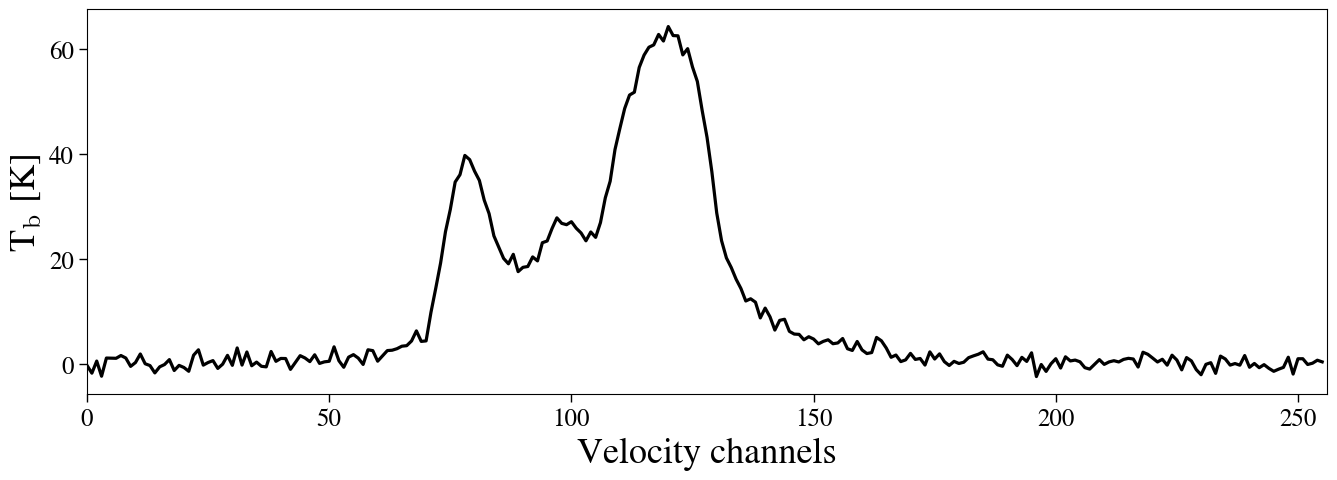

In [48]:
i = y[50]
j = x[50]
print(i,j)
fcnm_i = round(fcnm_data5[j, i], 2)
rhi_i = round(rhi_data5[j, i], 2)

# Plot
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(cube5[:, j, i], 'k-', lw=2.3, label='')

# plt.title('Training set')
ax.set_xlabel('Velocity channels', fontsize=26)
ax.set_ylabel('T$_\mathrm{b}$ [K]', fontsize=26)
ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=18)
ax.set_xlim(0, 256)

# plt.legend(loc='upper left', fontsize=12)

plt.show()

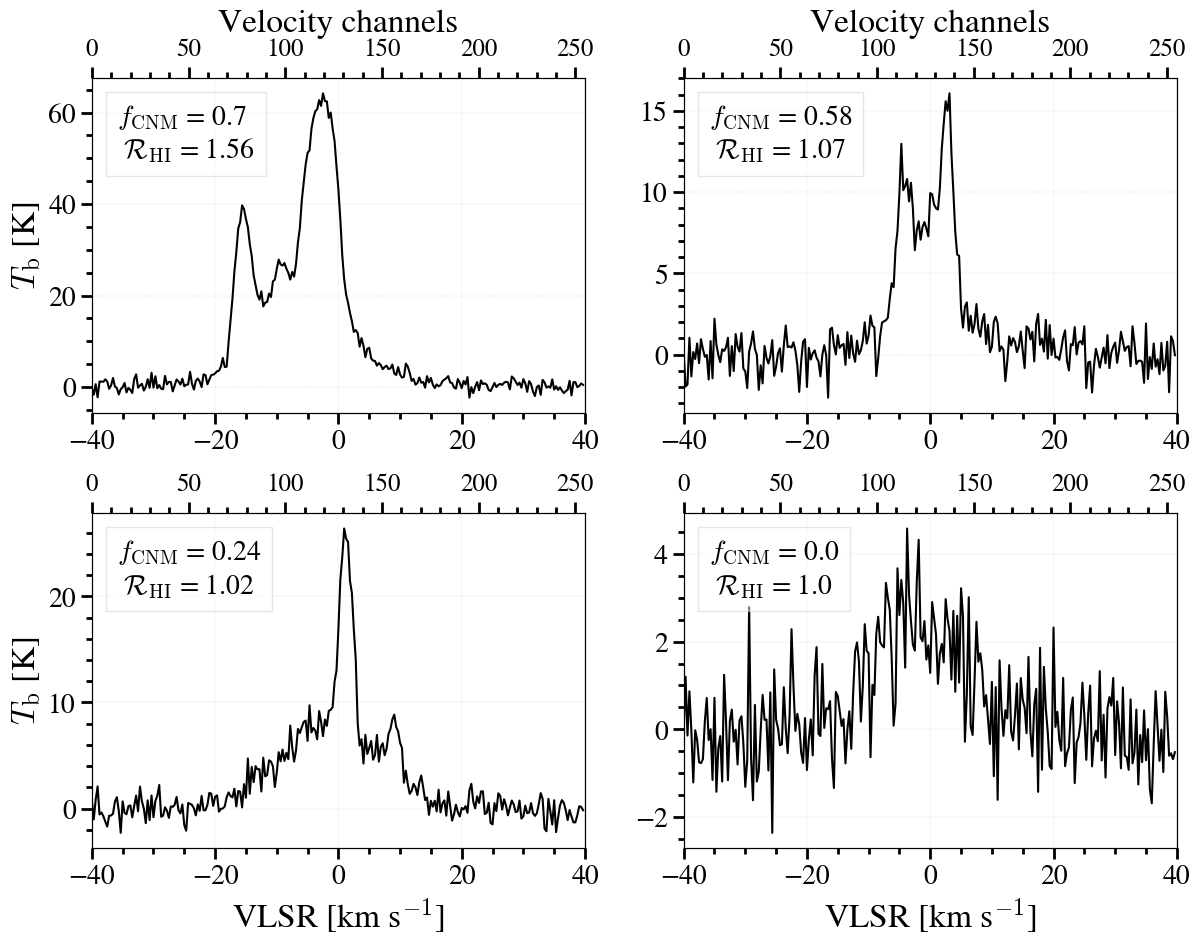

In [49]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(221)


i = 405
j = 25
fcnm_i = round(fcnm_data5[j, i], 2)
rhi_i = round(rhi_data5[j, i], 2)

ax.plot(v, cube5[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))

ax.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=24)

# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

ax.set_xlim(-40, 40.)

ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

ploti, = ax2.plot(cube5[:, j, i], color='k', label='')
ploti.set_visible(False)


ax2.set_xlabel('Velocity channels', fontsize=24)


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)





# axis
ax = fig.add_subplot(222)

i = 150
j = 460
fcnm_i = round(fcnm_data4[j, i], 2)
rhi_i = round(rhi_data4[j, i], 2)

# Plot
ax.plot(v, cube4[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))


# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

ax.set_xlim(-40, 40.)

ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

ploti, = ax2.plot(cube4[:, j, i], color='k', label='')
ploti.set_visible(False)


ax2.set_xlabel('Velocity channels', fontsize=24)


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)







# ========
ax = fig.add_subplot(223)

i = 232
j = 200
fcnm_i = round(fcnm_data5[j, i], 2)
rhi_i = round(rhi_data5[j, i], 2)

# Plot
ax.plot(v, cube5[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))

ax.set_ylabel('$T_\mathrm{b}$ [K]', fontsize=24)
ax.set_xlabel('VLSR [km s$^{-1}$]', fontsize=24)

# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

ax.set_xlim(-40, 40.)



ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

ploti, = ax2.plot(cube5[:, j, i], color='k', label='')
ploti.set_visible(False)


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)






ax = fig.add_subplot(224)

i = 300
j = 300
fcnm_i = round(fcnm_data2[j, i], 2)
rhi_i = round(rhi_data2[j, i], 2)

# Plot
ax.plot(v, cube2[:, j, i], 'k-', label=r'$f_\mathrm{CNM}$ = '+str(fcnm_i)+'\n $\mathcal{R}_\mathrm{HI}$ = '+str(rhi_i))

# plt.title('Training set')
ax.set_xlabel('VLSR [km s$^{-1}$]', fontsize=24)



# Add axes labels
ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)

ax.set_xlim(-40., 40.)

ax.grid(True, linestyle='--', linewidth=0.25, color='lightgray', zorder=-10)
leg = ax.legend(loc='upper left', fancybox=False, framealpha=0.5, labelcolor='k', fontsize=20, handletextpad=-2.0)
[item.set_visible(False) for item in leg.legend_handles]


# Create a secondary x-axis on top
ax2 = ax.twiny()

ploti, = ax2.plot(cube2[:, j, i], color='k', label='')
ploti.set_visible(False)


# Add axes labels
ax2.minorticks_on()
ax2.tick_params(axis='x', labelsize=18, pad=4)
ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8)
ax2.tick_params(which='minor', length=4)
ax2.set_xlim(0,255)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.3
                    )

# Save: spectra_eg.png
# plt.tight_layout()
plt.show()
plt.close()

# Histograms of $f_\text{CNM}$ and $R_\text{HI}$

In [51]:
fcnm_flat_data1 = fcnm_data1.flatten()
fcnm_flat_data2 = fcnm_data2.flatten()
fcnm_flat_data3 = fcnm_data3.flatten()
fcnm_flat_data4 = fcnm_data4.flatten()
fcnm_flat_data5 = fcnm_data5.flatten()

rhi_flat_data1 = rhi_data1.flatten()
rhi_flat_data2 = rhi_data2.flatten()
rhi_flat_data3 = rhi_data3.flatten()
rhi_flat_data4 = rhi_data4.flatten()
rhi_flat_data5 = rhi_data5.flatten()

In [53]:
bighicat_fcnm = bighicat_fcnm[~np.isnan(bighicat_fcnm)]
bighicat_fcnm.shape

(269,)

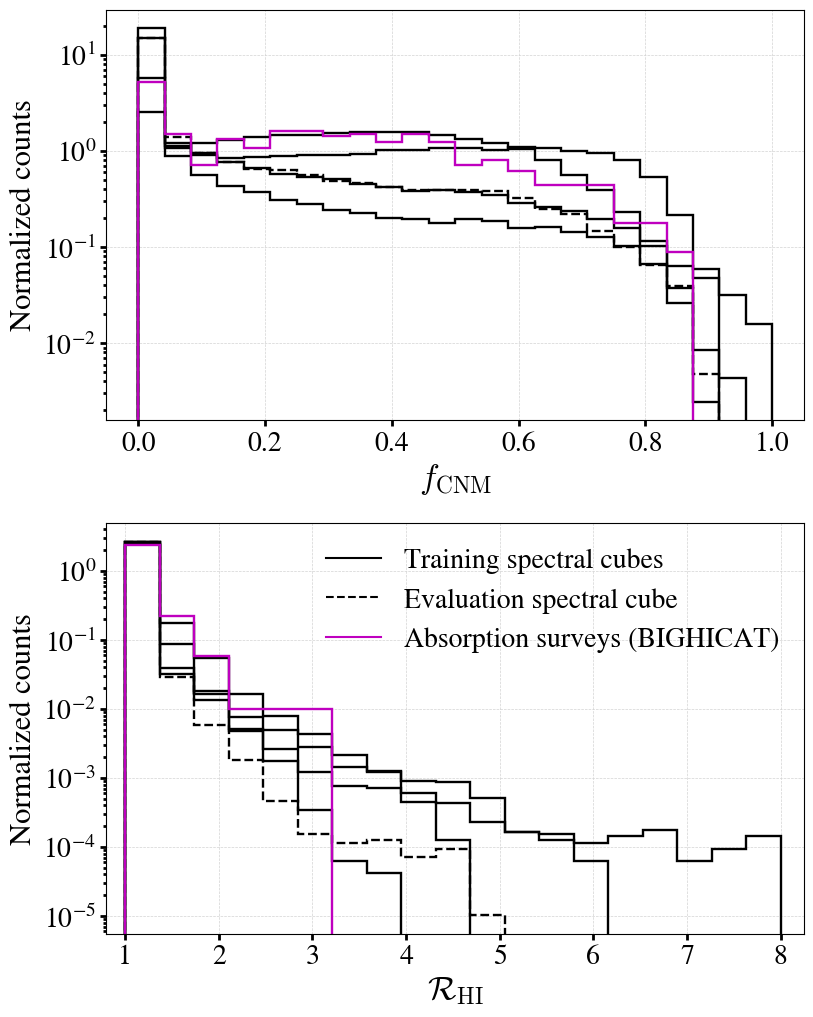

In [54]:
fig = plt.figure(figsize=(9,12))


# Plot:
ax = fig.add_subplot(211)

lw = 1.7
ls = '-'

nbins = 25
ax.hist(fcnm_flat_data1, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data2, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data4, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls='--', lw=lw,
         label='')

ax.hist(fcnm_flat_data3, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data5, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

plt.hist(bighicat_fcnm, bins=np.linspace(0., 1., nbins),
         density=True, color='m', histtype='step', alpha=1.,
         ls='-', lw=lw, label='')

plt.yscale('log')


# Add axes labels
ax.set_xlabel(r'$f_\mathrm{CNM}$', fontsize=24)
ax.set_ylabel(r'Normalized counts', fontsize=22)



ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)




# Plot:
ax = fig.add_subplot(212)

ls = '-'
nbins = 20

ax.hist(rhi_flat_data1, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data2, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data4, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls='--', lw=lw,
         label='')

ax.hist(rhi_flat_data3, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(rhi_flat_data5, bins=np.linspace(1., 8., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')


ax.hist(bighicat_rhi, bins=np.linspace(1., 8., nbins),
         density=True, color='m', histtype='step',
         alpha=1., ls='-', lw=lw,
         label='')


ploti, = ax.plot([], [], 'k-', label='Training spectral cubes')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'k--', label='Evaluation spectral cube')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'm-', label='Absorption surveys (BIGHICAT)')
ploti.set_visible(True)


plt.yscale('log')



# Add axes labels
ax.set_xlabel(r'$\mathcal{R}_\mathrm{HI}$', fontsize=24)
ax.set_ylabel(r'Normalized counts', fontsize=22)


ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.set_xlim(0.8, 8.25)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper right', fancybox=False, framealpha=0.0, labelcolor='k', fontsize=20)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.25
                    )



plt.show()

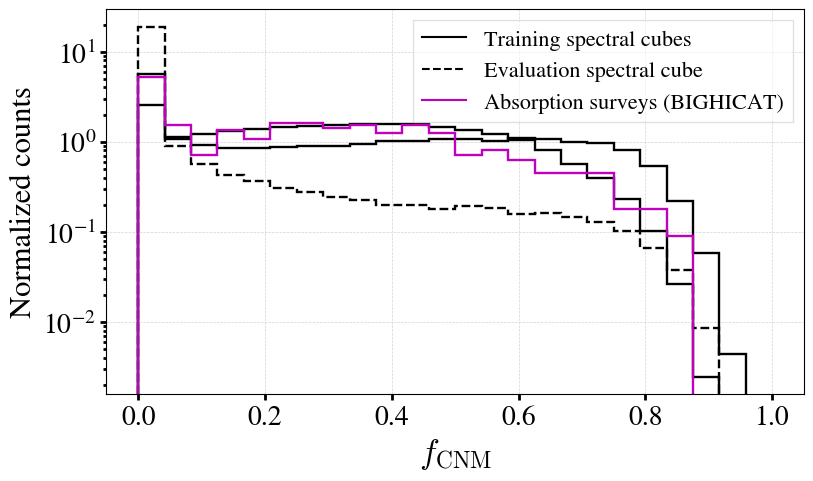

In [55]:
fig = plt.figure(figsize=(9,5))



# Plot:
ax = fig.add_subplot(111)

lw = 1.7
ls = '-'

nbins = 25
ax.hist(fcnm_flat_data1, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

ax.hist(fcnm_flat_data2, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls='--', lw=lw,
         label='')

ax.hist(fcnm_flat_data5, bins=np.linspace(0., 1., nbins),
         density=True, color='k', histtype='step',
         alpha=1., ls=ls, lw=lw,
         label='')

plt.hist(bighicat_fcnm, bins=np.linspace(0., 1., nbins),
         density=True, color='m', histtype='step', alpha=1.,
         ls='-', lw=lw, label='')



ploti, = ax.plot([], [], 'k-', label='Training spectral cubes')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'k--', label='Evaluation spectral cube')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'm-', label='Absorption surveys (BIGHICAT)')
ploti.set_visible(True)


plt.yscale('log')


# Add axes labels
ax.set_xlabel(r'$f_\mathrm{CNM}$', fontsize=24)
ax.set_ylabel(r'Normalized counts', fontsize=22)


ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
ax.legend(loc='upper right', fancybox=False, framealpha=0.6, labelcolor='k', fontsize=16)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.2,
                    hspace=0.25
                    )



plt.show()

In [56]:
print('BIGHICAT fCNM min, max:', bighicat_fcnm.min(), bighicat_fcnm.max())

BIGHICAT fCNM min, max: 0.0 0.8747913188647747


In [58]:
print('BIGHICAT RHI min, max:', bighicat_rhi.min(), bighicat_rhi.max())

BIGHICAT RHI min, max: 1.0 3.118108208174369
